In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns;
sns.set()

### Introducing K-Means

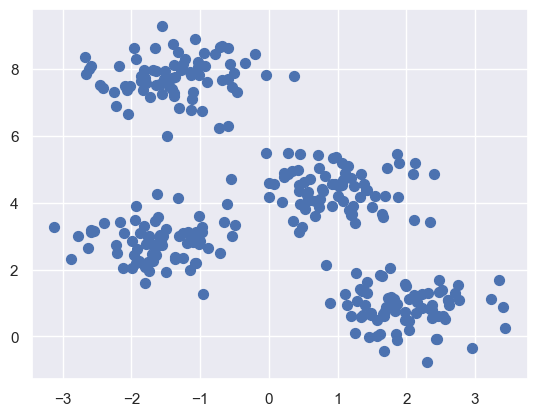

In [2]:
from sklearn.datasets import make_blobs

X,y_true=make_blobs(n_samples=300, centers=4,
                   random_state=0, cluster_std=0.60)
plt.scatter(X[:,0],X[:,1], s=50);

In [3]:
from sklearn.cluster import KMeans
KMeans=KMeans(n_clusters=4)
KMeans.fit(X)
y_kmeans=KMeans.predict(X)

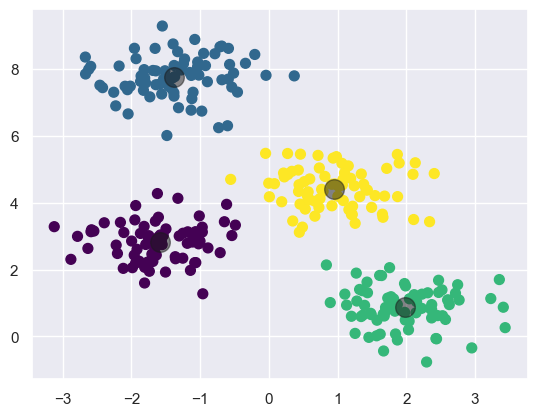

In [4]:
plt.scatter(X[:,0],X[:,1],c=y_kmeans, s=50, cmap='viridis')

centers=KMeans.cluster_centers_
plt.scatter(centers[:,0],centers[:,1], c='k', s=200, alpha=0.50);

### k-Means Algorithm: Expectation–Maximization

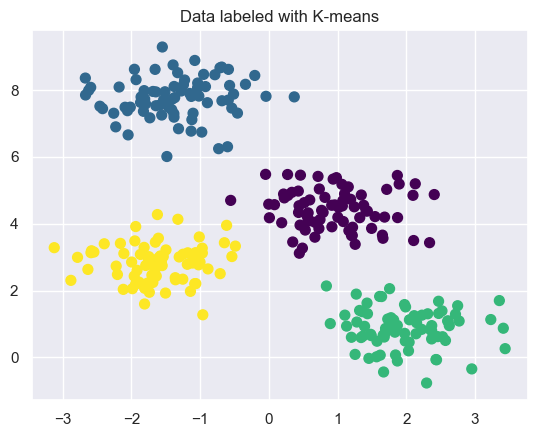

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X,n_clusters, rseed=2):
    #Randomly choose clusters
    rng=np.random.RandomState(rseed)
    i=rng.permutation(X.shape[0])[:n_clusters]
    centers=X[i]
    
    while True:
        #assign labels based on closest center
        labels=pairwise_distances_argmin(X, centers)
        
        #find new centers from means of points
        new_centers=np.array([X[labels==i].mean(0)
                             for i in range(n_clusters)])
        
        #check for convergence
        if np.all(centers==new_centers):
            break
        centers=new_centers
        
    return centers, labels
centers, labels=find_clusters(X,4)
plt.scatter(X[:,0],X[:,1], c=labels, s=50, cmap='viridis')
plt.title('Data labeled with K-means');

###### Caveats of expectation–maximization

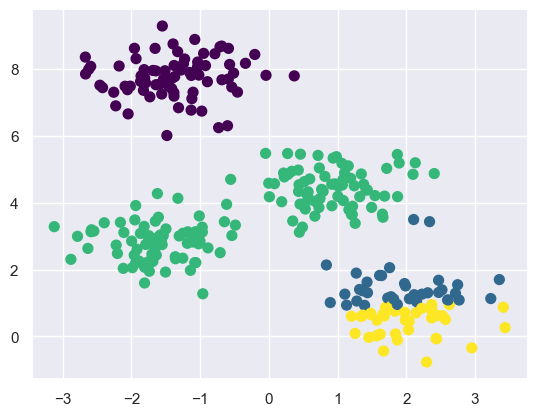

In [6]:
#the globally optimal result may not be achieved
centers, labels=find_clusters(X,4, rseed=0)
plt.scatter(X[:,0],X[:,1], c=labels, s=50, cmap='viridis');

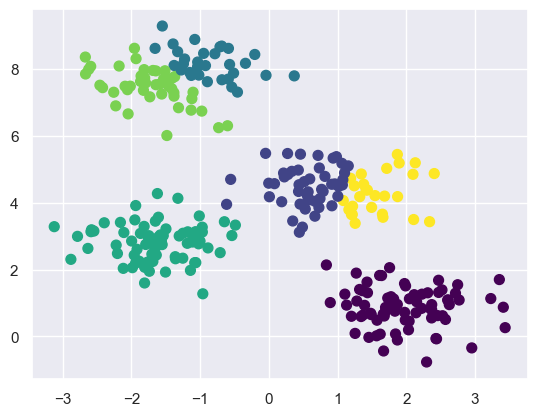

In [7]:
#the number of clusters must be selected beforehand
from sklearn.cluster import KMeans
KMean=KMeans(6,random_state=0)
labels=KMean.fit_predict(X)
plt.scatter(X[:,0],X[:,1],c=labels,s=50, cmap='viridis');

In [8]:
#K-means is limited to linear cluster boundaries
from sklearn.datasets import make_moons
X,y=make_moons(200,random_state=0)

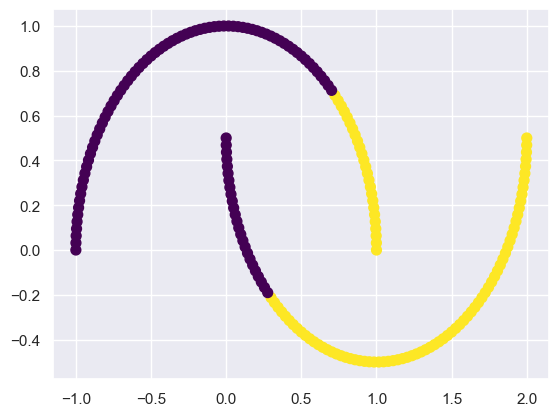

In [9]:
labels=KMeans(2,random_state=0).fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=labels, s=50,cmap='viridis');

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


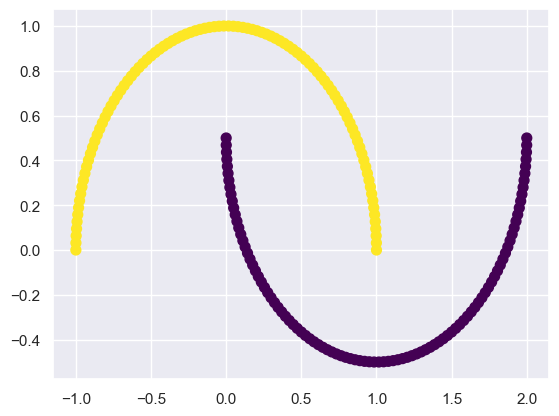

In [10]:
from sklearn.cluster import SpectralClustering
model=SpectralClustering(n_clusters=2,
                        affinity='nearest_neighbors',
                        assign_labels='kmeans')
labels=model.fit_predict(X)
plt.scatter(X[:,0],X[:,1],c=labels, s=50, cmap='viridis');

#### Example 1: k-Means on digits

In [11]:
from sklearn.datasets import load_digits
digits=load_digits()
digits.data.shape

(1797, 64)

In [12]:
kmeans=KMeans(n_clusters=10, random_state=0)
clusters=kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

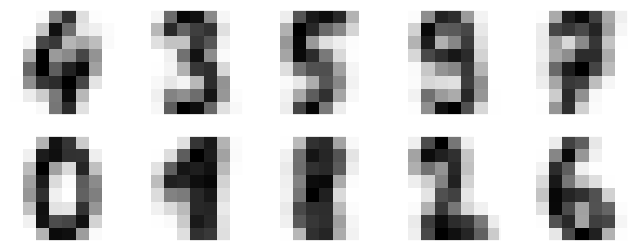

In [13]:
fig, ax=plt.subplots(2,5, figsize=(8,3))
centers=kmeans.cluster_centers_.reshape(10,8,8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[],yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [14]:
from scipy.stats import mode

labels=np.zeros_like(clusters)
for i in range(10):
    mask=(clusters==i)
    labels[mask]=mode(digits.target[mask])[0]

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

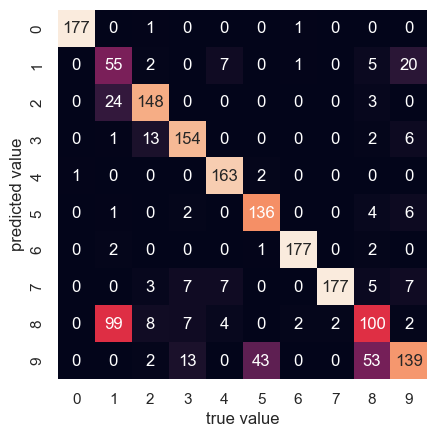

In [16]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(digits.target, labels)
sns.heatmap(mat.T,square=True,annot=True, fmt='d',cbar=False,
           xticklabels=digits.target_names,
           yticklabels=digits.target_names)
plt.xlabel('true value')
plt.ylabel('predicted value');

In [17]:
#just for fun, let's continue working on this digits(hahaha)
#use the t-distributed stochastic neighbor embedding(t-SNE)
from sklearn.manifold import TSNE

#project the data:this step will take several seconds 
tsne=TSNE(n_components=2, init='pca', random_state=0)
digits_proj=tsne.fit_transform(digits.data)

#compute the clusters
kmeans=KMeans(n_clusters=10, random_state=0)
clusters=kmeans.fit_predict(digits_proj)

#permute the labels
labels=np.zeros_like(clusters)
for i in range(10):
    mask=(clusters==i)
    labels[mask]=mode(digits.target[mask])[0]
    
#compute the accuracy
accuracy_score(digits.target, labels)

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


0.9432387312186978

#### Example 2: k-means for color compression

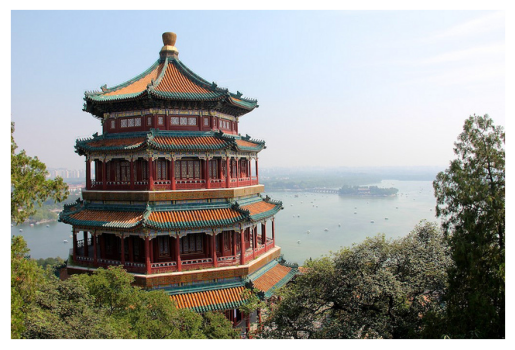

In [18]:
# Note: this requires the pillow package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [19]:
china.shape

(427, 640, 3)

In [20]:
#rescale the colors so they lie between 0 and 1in a 3d color space
data=china/255.0 #use 0..1 scale 
data=data.reshape(427*640,3)
data.shape

(273280, 3)

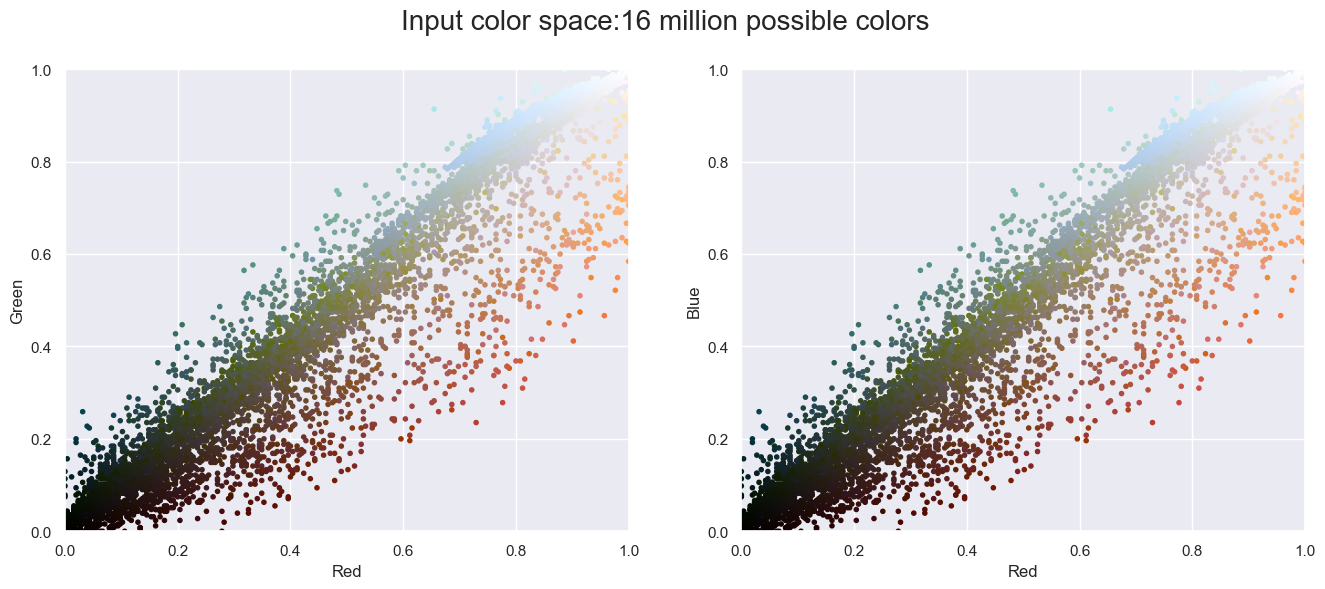

In [22]:
#visualize these pixels  using a subset of 10,000 pixels for efficiency 
def plot_pixels(data,title, colors=None,N=10000):
    if colors is None:
        colors=data
        
    #choose a random subset
    rng=np.random.RandomState(0)
    i=rng.permutation(data.shape[0])[:N]
    colors=colors[i]
    R,G,B=data[i].T
    
    fig, ax=plt.subplots(1,2, figsize=(16,6))
    ax[0].scatter(R,G, color=colors, marker='.')
    ax[0].set(xlabel='Red',ylabel='Green',xlim=(0,1), ylim=(0,1))
    
    ax[1].scatter(R,G, color=colors, marker='.')
    ax[1].set(xlabel='Red',ylabel='Blue', xlim=(0,1),ylim=(0,1))
    
    fig.suptitle(title, size=20);
    
plot_pixels(data,title='Input color space:16 million possible colors')

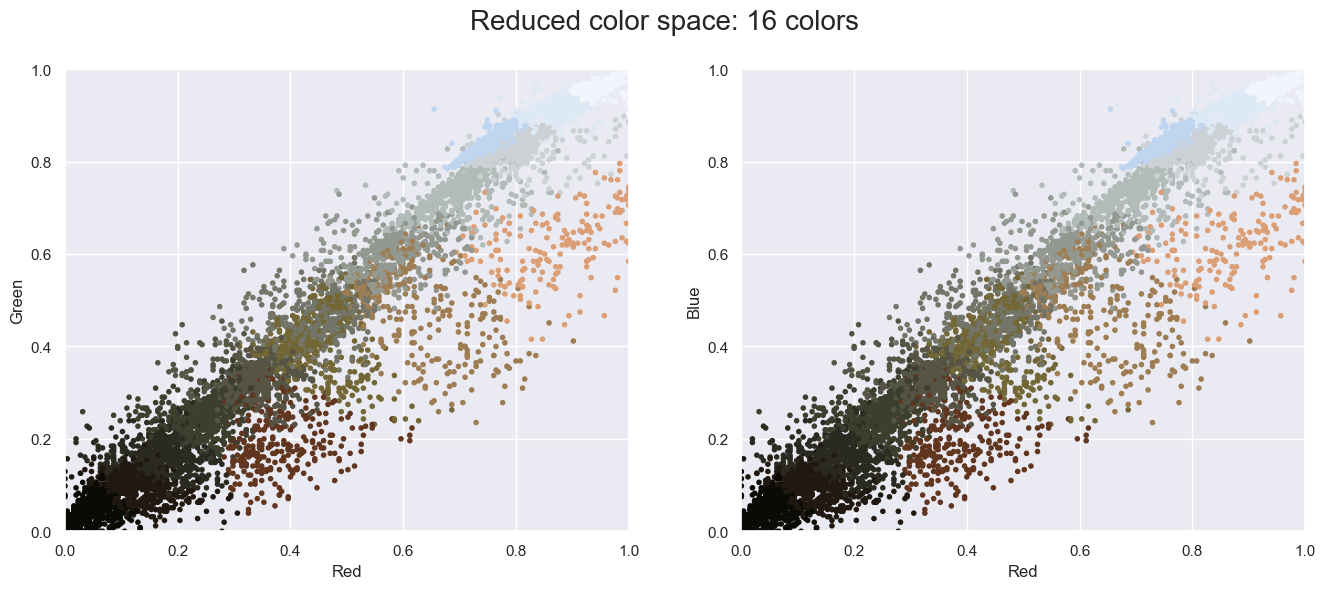

In [26]:
#reduce these 16M colors to just 16 colors using K-means
from sklearn.cluster import MiniBatchKMeans
kmeans=MiniBatchKMeans(16)
kmeans.fit(data)
new_colors=kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
           title='Reduced color space: 16 colors')

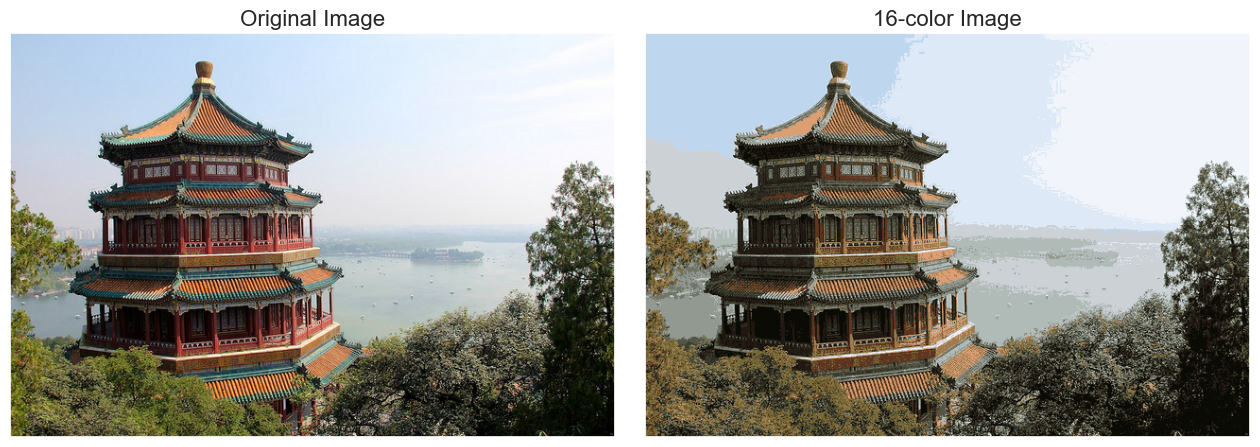

In [27]:
#let's go back to our china image
china_recolored=new_colors.reshape(china.shape)

fig,ax=plt.subplots(1,2, figsize=(16,6),
                   subplot_kw=dict(xticks=[],yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);